## Import thư viện

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import RobustScaler
from colorama import Fore
from sklearn import metrics
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.decomposition import PCA 
from xgboost import XGBRegressor
import math
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

In [2]:
sns.set_style("white")


## Load dữ liệu

In [77]:
df = pd.read_csv("clean data/hotels.csv")
data = df.drop(["Name", "Address"], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                1011 non-null   int64  
 1   Size                 1011 non-null   int64  
 2   Distance to beach    1011 non-null   float64
 3   Distance to airport  1011 non-null   float64
 4   Pool                 1011 non-null   int64  
 5   Car                  1011 non-null   int64  
 6   Non-smoking room     1011 non-null   int64  
 7   Near beach           1011 non-null   int64  
 8   WiFi                 1011 non-null   int64  
 9   Family room          1011 non-null   int64  
 10  Bar                  1011 non-null   int64  
 11  Breakfast            1011 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 94.9 KB


In [78]:
data["Type"] = data["Price"].apply(lambda x: 0 if x<1000 else (1 if x < 5000 else 2))


In [34]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(data[["Distance to beach","Size", "Distance to airport",  "Pool"]])
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=data["Price"])
fig.show()

## Phân chia train set và val set

In [79]:
X = data.drop(["Type"] , axis=1)
y = data["Type"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
p_val = X_val["Price"]
X_train = X_train.drop(["Price"], axis = 1)
X_val = X_val.drop(["Price"], axis = 1)

### Hàm này dùng để đánh giá mô hình

### Sử dụng 3 metrics: MAE, RMSE và MAPE để nhanh chóng đánh giá sơ bộ kết quả của mô hình

In [5]:

#this function used to evaluate the models.
def models_score(x_train, x_val, y_train, y_val):    
    models = {
        "Linear": LinearRegression(),
        "RandomForest":RandomForestRegressor(),
         }
    evalutes = {}
    i = 0
    maes = []
    rmse = []
    mape = []
    names = []
    for name, model in models.items():
        model.fit(x_train, y_train)
        y_pred=model.predict(x_val) 
        names.append(name)
        maes.append(mean_absolute_error(y_val,y_pred))
        rmse.append(math.sqrt(mean_squared_error(y_val,y_pred)))
        mape.append(mean_absolute_percentage_error(y_val, y_pred))
    evalutes = {'Algorithms': names, 'MAE': maes, 'RMSE': rmse, "MAPE":mape}
    model_scores = pd.DataFrame(evalutes)
    return model_scores

## Feature Extraction

### Khảo sát hiệu suất mô hình trước khi thực hiện trích xuất đặc trưng

In [6]:
score = models_score(X_train, X_val, y_train, y_val)
score

,Algorithms,MAE,RMSE,MAPE
0,Linear,602.329064,1013.410572,0.686749
1,RandomForest,471.605698,926.298304,0.403890


### Sử dụng PCA để giảm chiều dữ liệu

In [7]:
scores = []
for i in range(1, 12):
  pca = PCA(n_components=i)
  pca.fit(X_train)
  X_train_pca = pca.transform(X_train)
  X_val_pca = pca.transform(X_val)
  scores.append(models_score(X_train_pca, X_val_pca, y_train, y_val))

best_score = scores[4] #kết quả tốt nhất khi n_components = 5
best_score

,Algorithms,MAE,RMSE,MAPE
0,Linear,593.749632,1013.652110,0.665944
1,RandomForest,456.824026,1064.060642,0.389808


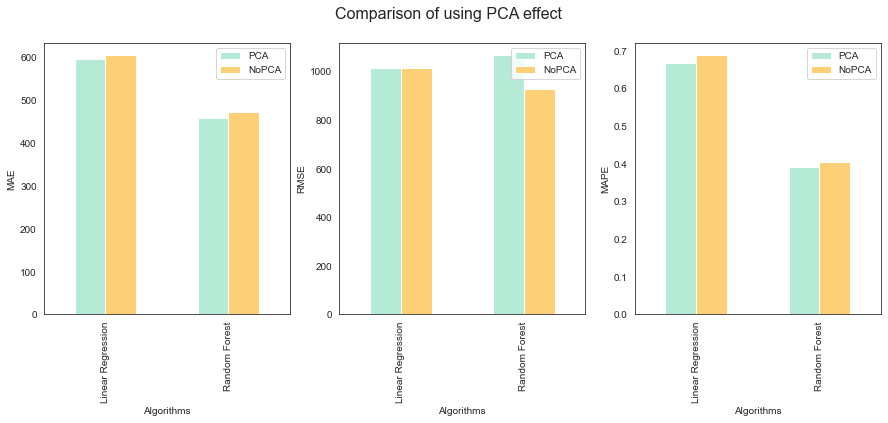

In [8]:

metrics = ["MAE", "RMSE", "MAPE"]
fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Comparison of using PCA effect', fontsize=16) 
for i in range(len(metrics)):
    df_comparea_pca = pd.DataFrame({
        'Algorithms': ["Linear Regression", "Random Forest"],
        'PCA': [best_score[metrics[i]][0], best_score[metrics[i]][1]],
        'NoPCA': [score[metrics[i]][0], score[metrics[i]][1]],
    })
    df_comparea_pca.plot(x="Algorithms", y=["PCA", "NoPCA"], kind="bar", ax = axs[i], color=['#b5ead7', '#fdcf76']
)
    axs[i].set_ylabel(metrics[i])


=> PCA không cải thiện nhiều hiệu suất mô hình, vậy nên chúng ta không áp dụng PCA

### Tạo thêm các biến mới
- Ở đây, chúng ta sẽ tạo thêm 2 biến mới:
    - Ratio: tỉ lệ giữa khoảng cách từ khách sạn đến biển và khoảng cách từ khách sạn đến sân bay
    - Facilities: số lượng các dịch vụ được ưa chuộng nhất mà khách sạn cung cấp
- Dựa trên kết quả EDA, chúng ta sẽ muốn Ratio sẽ có mối quan hệ nghịch biến với Price
- Theo thường thức, Facilities nên có quan hệ đồng biến với Price

In [81]:
def create_new_feature(X):
    tmp = X.copy()
    facs = [ "Pool", "Bar",'Car','Non-smoking room','WiFi','Family room','Breakfast', "Near beach"]
    tmp["Facilities"] = X[facs].sum(axis =1)
    tmp["Ratio"] = X["Distance to beach"] / X["Distance to airport"]
    return tmp

In [82]:
tmp_data = create_new_feature(data)
tmp_data.corr()

,Price,Size,Distance to beach,Distance to airport,Pool,Car,Non-smoking room,Near beach,WiFi,Family room,Bar,Breakfast,Type,Facilities,Ratio
Price,1.000000,0.830076,-0.164909,0.384179,0.306330,0.104705,-0.034993,0.058262,0.049186,-0.038160,0.227594,-0.032213,0.759923,0.194401,-0.051582
Size,0.830076,1.000000,-0.105079,0.296037,0.216788,0.035101,-0.076284,0.030093,0.022754,-0.070643,0.105783,-0.046014,0.654369,0.079618,-0.039015
Distance to beach,-0.164909,-0.105079,1.000000,-0.477759,-0.181876,-0.152920,0.046326,-0.430387,-0.013939,-0.038621,-0.096419,-0.034004,-0.210091,-0.257528,0.323886
Distance to airport,0.384179,0.296037,-0.477759,1.000000,0.227717,0.121489,-0.008528,0.248651,0.008730,-0.033619,0.188360,0.016225,0.368157,0.224411,-0.247859
Pool,0.306330,0.216788,-0.181876,0.227717,1.000000,0.222374,0.057487,0.115377,0.120663,0.101077,0.393270,0.087355,0.440167,0.580799,-0.088610
Car,0.104705,0.035101,-0.152920,0.121489,0.222374,1.000000,0.227672,0.157294,0.095995,0.255461,0.204670,0.074634,0.066596,0.610568,-0.088180
Non-smoking room,-0.034993,-0.076284,0.046326,-0.008528,0.057487,0.227672,1.000000,0.033653,0.114418,0.364817,0.203763,0.052209,-0.118460,0.505911,-0.050499
Near beach,0.058262,0.030093,-0.430387,0.248651,0.115377,0.157294,0.033653,1.000000,-0.008765,0.169506,0.103311,0.047622,0.143066,0.455447,-0.096217
WiFi,0.049186,0.022754,-0.013939,0.008730,0.120663,0.095995,0.114418,-0.008765,1.000000,0.072881,0.117530,0.045750,0.027645,0.320179,-0.112549
Family room,-0.038160,-0.070643,-0.038621,-0.033619,0.101077,0.255461,0.364817,0.169506,0.072881,1.000000,0.184681,0.056472,-0.034424,0.559172,0.002064


- Từ bảng tương quan ta có thể thấy các dự đoán của chúng ta là tương đối chính xác

### Thêm 2 đặc trưng mới vào tập train và val

In [83]:

X_train = create_new_feature(X_train)
X_val = create_new_feature(X_val)


In [85]:
X_train

,Size,Distance to beach,Distance to airport,Pool,Car,Non-smoking room,Near beach,WiFi,Family room,Bar,Breakfast,Facilities,Ratio
0,22,0.85,4.1,1,0,1,0,1,1,0,0,4,0.207317
1,25,0.30,4.5,0,1,1,1,1,1,0,0,5,0.066667
2,28,0.20,4.3,0,1,1,1,1,1,1,0,6,0.046512
3,35,0.20,4.8,1,1,1,1,1,1,0,0,6,0.041667
4,18,0.25,4.4,0,0,1,0,1,1,0,0,3,0.056818
...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,68,0.10,4.4,1,0,0,0,1,1,0,0,3,0.022727
703,22,2.40,2.6,0,1,1,0,1,1,0,0,4,0.923077
704,25,0.25,4.5,0,1,1,0,1,1,0,0,4,0.055556
705,25,0.45,4.1,0,0,0,0,1,1,1,0,3,0.109756


## Feature Selection

### Đối vói mô hình Linear Regression

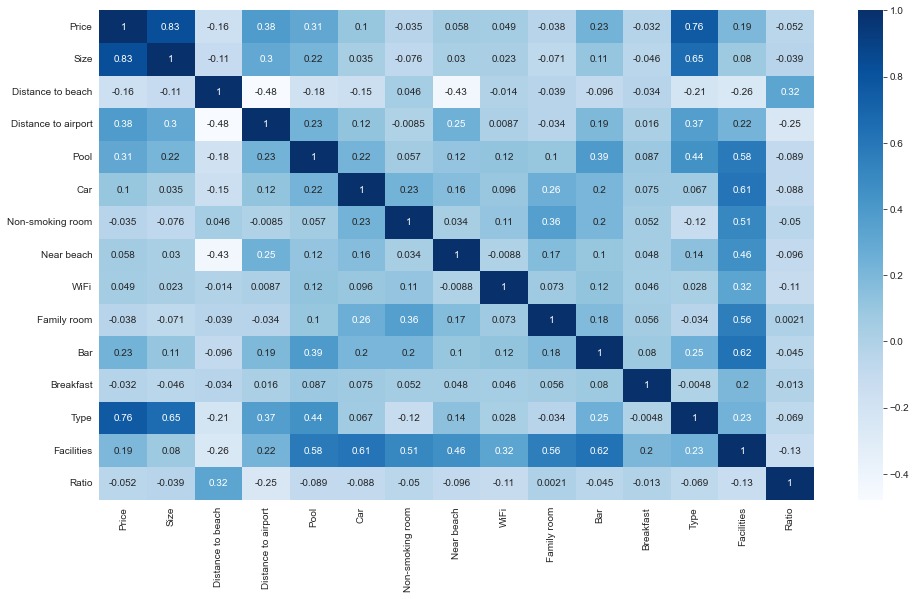

In [72]:
plt.figure(figsize = (16, 9))
dataplot = sns.heatmap(tmp_data.corr(), annot = True, cmap= "Blues")

### Từ correlation map, ta thấy top 4 các đặc trưng quan trọng cho mô hình Linear Regression là: 
- Size
- Distance to beach
- Distance to airport
- Facilities

### Đối với mô hình Random Forest


In [89]:
tmp_data

,Price,Size,Distance to beach,Distance to airport,Pool,Car,Non-smoking room,Near beach,WiFi,Family room,Bar,Breakfast,Type,Facilities,Ratio
0,440,26,2.10,3.2,0,1,1,0,1,0,0,0,0,3,0.656250
1,333,22,0.25,4.3,0,1,0,1,0,1,0,0,0,3,0.058140
2,400,26,0.15,4.6,1,1,1,1,1,1,1,1,0,8,0.032609
3,256,19,1.80,3.4,0,1,1,0,1,1,0,0,0,4,0.529412
4,425,25,0.25,4.3,0,1,1,0,1,1,0,0,0,4,0.058140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,9000,1000,0.55,4.1,0,0,0,0,1,0,0,0,2,1,0.134146
1007,4195,250,0.30,4.8,1,0,1,0,1,1,0,0,1,4,0.062500
1008,5880,130,0.25,6.0,1,0,0,1,1,1,1,0,2,5,0.041667
1009,9750,500,0.20,9.0,1,1,1,1,1,0,1,0,2,6,0.022222


Feature: 0, Score: 0.34774
Feature: 1, Score: 0.13756
Feature: 2, Score: 0.12086
Feature: 3, Score: 0.05910
Feature: 4, Score: 0.02015
Feature: 5, Score: 0.01593
Feature: 6, Score: 0.01828
Feature: 7, Score: 0.01183
Feature: 8, Score: 0.01268
Feature: 9, Score: 0.02303
Feature: 10, Score: 0.00245
Feature: 11, Score: 0.05418
Feature: 12, Score: 0.17621


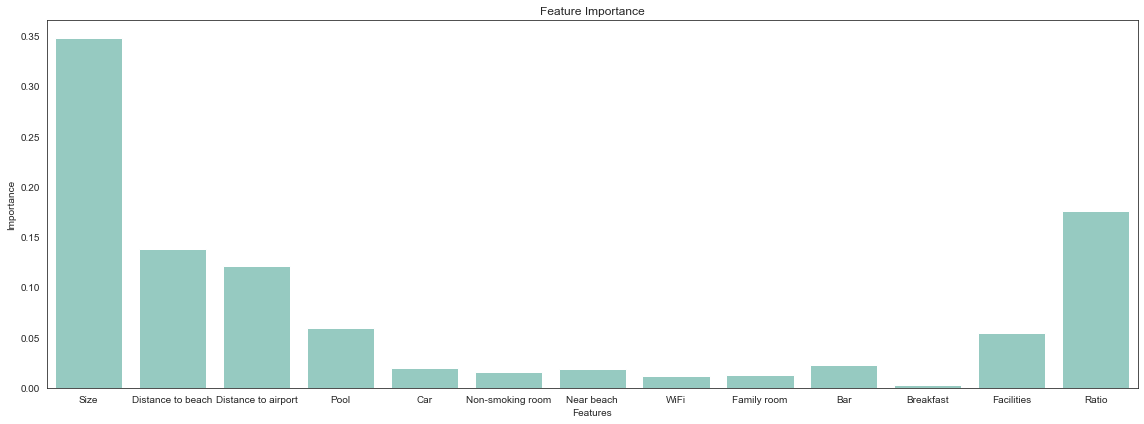

In [91]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

plt.figure(figsize=(16, 6)) 
sns.barplot(x=list(X_train.columns), y=importance)


plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")

plt.tight_layout()
plt.show()

### Từ đây, ta thấy được top 5 feature cho mô hình random forest là: 
 - Size
 - Distance to beach
 - Distance to airport
 - Facilities
 - Ratio

### Ngoài ra, từ kết quả EDA, ta thấy 2 biến Pool và Bar cũng có ảnh hưởng đến biến mục tiêu, vậy nên ta sẽ chọn thêm 1 biến Pool và Bar
=> Như vậy, 2 mô hình của chúng ta sẽ có 7 features:
- Size
- Distance to beach
- Distance to airport
- Pool
- Bar
- Facilities
- Ratio

### Chọn ra những feature quan trọng

In [46]:
selected_features = ["Size", "Distance to beach", "Distance to airport", "Pool", "Bar", "Facilities", "Ratio"]
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_train

,Size,Distance to beach,Distance to airport,Pool,Bar,Facilities,Ratio
0,22,0.85,4.1,1,0,4,0.207317
1,25,0.30,4.5,0,0,5,0.066667
2,28,0.20,4.3,0,1,6,0.046512
3,35,0.20,4.8,1,0,6,0.041667
4,18,0.25,4.4,0,0,3,0.056818
...,...,...,...,...,...,...,...
702,68,0.10,4.4,1,0,3,0.022727
703,22,2.40,2.6,0,0,4,0.923077
704,25,0.25,4.5,0,0,4,0.055556
705,25,0.45,4.1,0,1,3,0.109756


## Feature Transformation

### Dữ liệu trước khi scale

Text(0.5, 0, 'Distance to airport (km)')

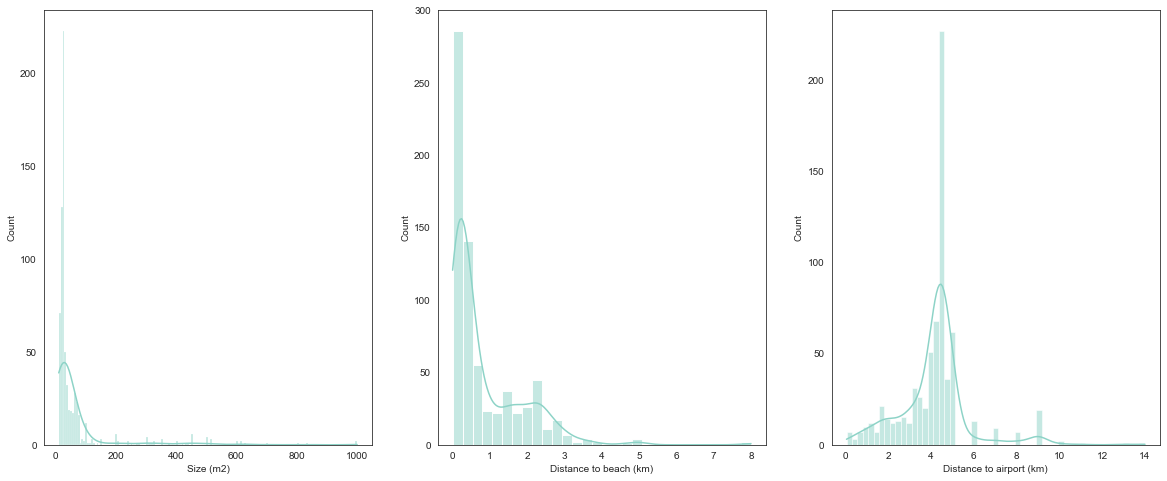

In [64]:
fig = plt.figure(figsize = (20, 8))
gs = gridspec.GridSpec(1, 3)

size = fig.add_subplot(gs[0, 0])
sns.histplot(data=X_train["Size"], ax = size, kde = True)
size.set_xlabel("Size (m2)")

beach = fig.add_subplot(gs[0, 1])
sns.histplot(data=X_train["Distance to beach"], ax = beach, kde = True)
beach.set_xlabel("Distance to beach (km)")

airport = fig.add_subplot(gs[0, 2])
sns.histplot(data=X_train["Distance to airport"], ax = airport, kde = True)
airport.set_xlabel("Distance to airport (km)")

### Thực hiện Scaling bằng Robust Scaler vì dữ liệu chứa nhiều outlier

In [96]:
def scale_data(x):
    x = np.array(x)
    x = np.reshape(x, (len(x), 1))
    scaler = RobustScaler(quantile_range=(15,85))
    x = scaler.fit_transform(x)
    return x

def transform(x):
    x = np.array(x)
    x = np.log(x)
    return x

### Thực hiện scale trên các biến numerical

In [97]:
features = ["Size", "Distance to beach", "Distance to airport"]
for feature in features:
    X_train[feature] = scale_data(X_train[[feature]])
    X_val[feature] = scale_data(X_val[feature])
    

### Dữ liệu sau khi scale

Text(0.5, 0, 'Distance to airport (km)')

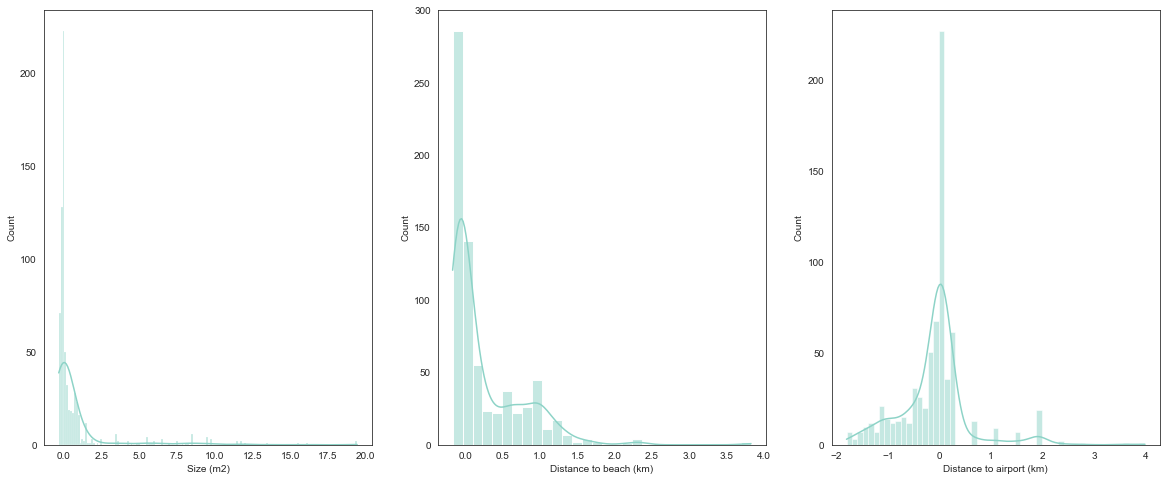

In [98]:
fig = plt.figure(figsize = (20, 8))
gs = gridspec.GridSpec(1, 3)

size = fig.add_subplot(gs[0, 0])
sns.histplot(data=X_train["Size"], ax = size, kde = True)
size.set_xlabel("Size (m2)")

beach = fig.add_subplot(gs[0, 1])
sns.histplot(data=X_train["Distance to beach"], ax = beach, kde = True)
beach.set_xlabel("Distance to beach (km)")

airport = fig.add_subplot(gs[0, 2])
sns.histplot(data=X_train["Distance to airport"], ax = airport, kde = True)
airport.set_xlabel("Distance to airport (km)")

## Xây dựng các class mô hình cho việc dự đoán và trình bày kết quả

In [92]:
class Model:
    def __init__(self):
        pass

    def predict(self, X_val):
        self.y_pred = self.model.predict(X_val)
        return self.y_pred
    
    
    # dùng để đánh giá mô hình trên metrics thông qua 4 metrics: MAE, RMSE, MAPE, R2 score
    def evaluate(self, y_true):
        self.score_mae = mean_absolute_error(y_true, self.y_pred)
        self.score_rmse = math.sqrt(mean_squared_error(y_true, self.y_pred))
        self.score_mape = mean_absolute_percentage_error(y_true, self.y_pred)
        self.r2 = r2_score(y_true, self.y_pred)
        
        print(Fore.GREEN + 'MAE: {}'.format(self.score_mae))
        print(Fore.GREEN + 'RMSE: {}'.format(self.score_rmse))
        print(Fore.GREEN + 'MAPE: {}'.format(self.score_mape))
        print(Fore.GREEN + 'R2: {}'.format(self.r2))
        
        return self.score_mae, self.score_rmse, self.score_mape, self.r2


    def plot_yy(self, width, height, y_pred, y_val):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        plt.scatter(y_val, y_pred, color='red')
        plt.plot(y_val, y_val)
        plt.grid()
        plt.xlabel('Actual price (Thousand VND)')
        plt.ylabel('Predicted price (Thousand VND)')
        plt.title('Scatter plot between actual y and predicted y')
        plt.show()
        
    def line_graph(self, width, height, y_val):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        x = np.arange(0, len(self.y_pred))
        sns.lineplot(x = x, y = self.y_pred, ax = ax, color = "blue", label = "Predicted")
        sns.lineplot(x = x, y = y_val, ax = ax, color = "red", label="Actual")
        ax.set_title(f'Prediction \n MAE: {self.score_mae:.2f}, RMSE: {self.score_rmse:.2f}, MAPE: {self.score_mape:.2f}, R2: {self.r2}', fontsize=14)
        ax.set_xlabel(xlabel='Sample', fontsize=14)
        ax.set_ylabel(ylabel="Price (Thousand VND)", fontsize = 14)
        ax.legend()
        
class ModelRandomForestClassifier(Model):
    def __init__(self):
        super().__init__()
        self.model = RandomForestClassifier()
    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        
        
        
class ModelLinearRegression(Model):
    def __init__(self, regular = False):
        self.regular = regular
    def train(self, X_train, y_train):
        if not self.regular:
            self.model = LinearRegression()
        else:
            self.model = Ridge(alpha = 0.2)
        self.model.fit(X_train, y_train)
        

class ModelRandomForest(Model):
    def __init__(self, model, search=False):
        self.model = model
        self.search = search
        self.params = {
                        'n_estimators': [100, 200, 300],
                        'max_depth': [10, 20, 30],
                        'min_samples_split': [2, 4, 8],
                        'min_samples_leaf': [1, 2, 4],
                        'max_features': [2, 3, 4],
                        'bootstrap': [True, False]
                    }
    def train(self, X_train, y_train):
        if not self.search:
            self.model.fit(X_train, y_train)
        else:
            grid_search = GridSearchCV(estimator=self.model, param_grid=self.params, cv=6, n_jobs=-1, verbose=3, scoring="r2")
            grid_search.fit(X_train, y_train)
            self.params = grid_search.best_params_
            self.model = RandomForestRegressor(**self.params)
            self.model.fit(X_train, y_train)
            print(grid_search.scorer_)

In [93]:
X_val

,Size,Distance to beach,Distance to airport,Pool,Car,Non-smoking room,Near beach,WiFi,Family room,Bar,Breakfast,Facilities,Ratio
0,32,0.90,3.70,1,1,1,0,1,1,1,0,6,0.243243
1,50,0.45,4.20,1,0,1,0,1,1,0,0,4,0.107143
2,25,0.01,6.00,1,1,1,1,1,1,1,0,7,0.001667
3,30,0.35,4.20,0,1,1,0,1,1,0,0,4,0.083333
4,18,0.15,4.60,0,1,1,1,1,1,0,0,5,0.032609
...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,25,0.20,4.60,0,1,0,0,0,0,0,0,1,0.043478
300,15,1.60,0.15,0,0,1,0,1,1,0,0,3,10.666667
301,27,0.65,4.10,1,0,1,0,1,1,1,0,5,0.158537
302,35,0.20,4.40,0,1,1,0,1,1,0,0,4,0.045455


In [94]:
def score(y_pred, y_true):
    s = 0
    for i in range(len(y_pred)):
        if y_pred[i] == y_true[i]:
            s+=1
    s /= len(y_pred)
    return s 



In [99]:
clsf = ModelRandomForestClassifier()
clsf.train(X_train, y_train)
pred = clsf.predict(X_val)
pred = pred.reshape(-1,1)
y_val = np.array(y_val).reshape(-1,1)
score(pred, y_val)


0.8421052631578947

In [100]:
pred = pred.ravel()

<Axes: xlabel='Size', ylabel='Price'>

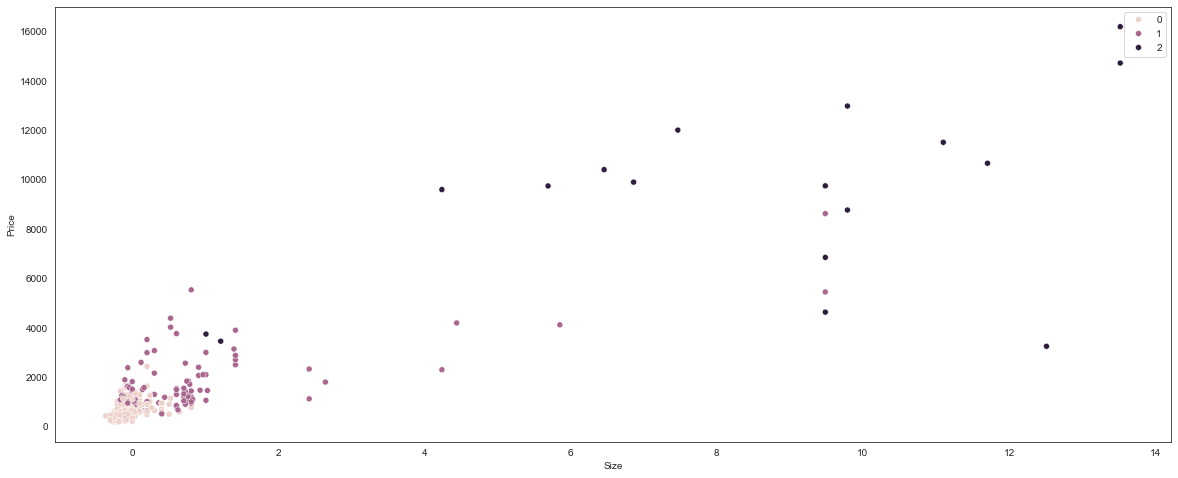

In [101]:
fig = plt.figure(figsize = (20, 8))
sns.scatterplot(x = X_val["Size"], y = p_val, hue = pred)


### Kết quả của Linear Regression

MAE: 585.6142865544366
RMSE: 1008.4388101703931
MAPE: 0.6415956462590796
R2: 0.8068738104595837


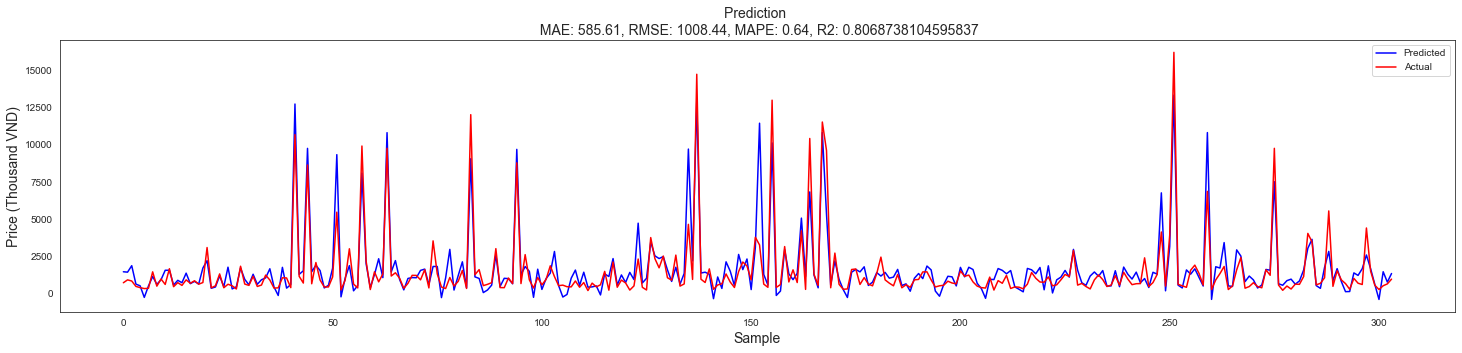

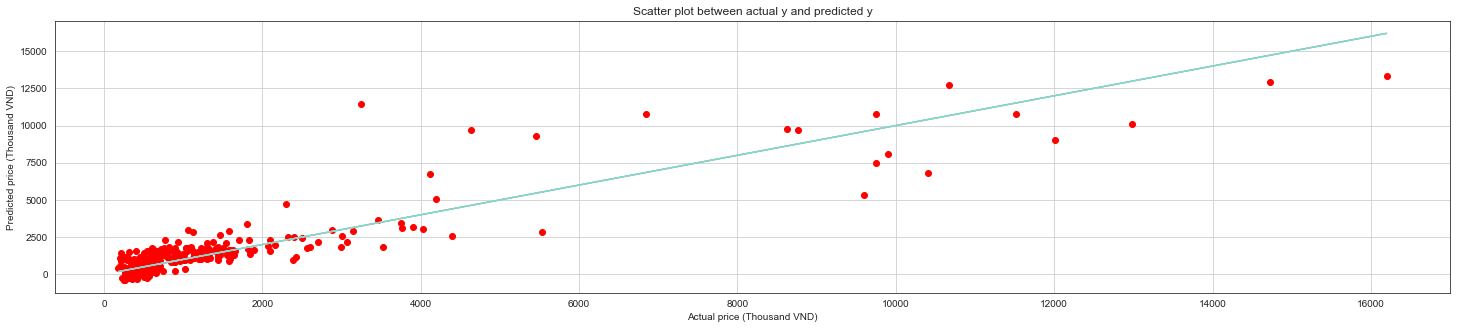

In [20]:
linear_reg = ModelLinearRegression()
linear_reg.train(X_train, y_train)
linear_y_pred = linear_reg.predict(X_val)
linear_score_mae, linear_score_rmse, linear_score_mape, linear_r2 = linear_reg.evaluate(y_val)
linear_reg.line_graph(25, 5, y_val)
linear_reg.plot_yy(25, 5, linear_y_pred, y_val)

In [21]:
print(linear_reg.model.score(X_train, y_train))
print(linear_reg.model.score(X_val, y_val))

0.7040271800369
0.8068738104595837


- MAPE cao: kết quả dự đoán còn lệch nhiều so với kết quả thực, đặc biệt là ở các mẫu có Price cao (đa số là thấp hơn giá trị thực)
- Mô hình cho ra kết quả khá tốt với phân khúc khách sạn giá vừa và thấp (~2 triệu đồng)

MAE: 444.9757371553884
RMSE: 863.3072900573052
MAPE: 0.36834203288083095
R2: 0.8584620550414496


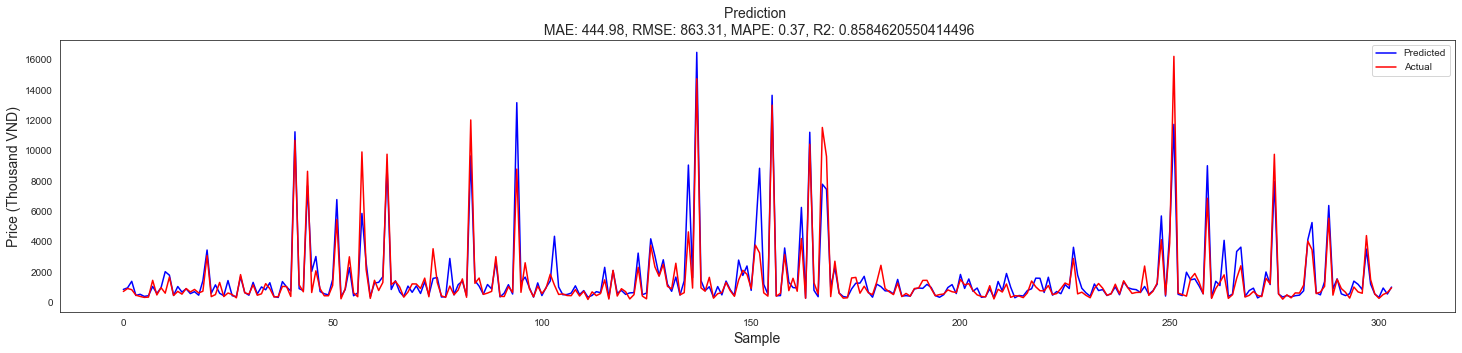

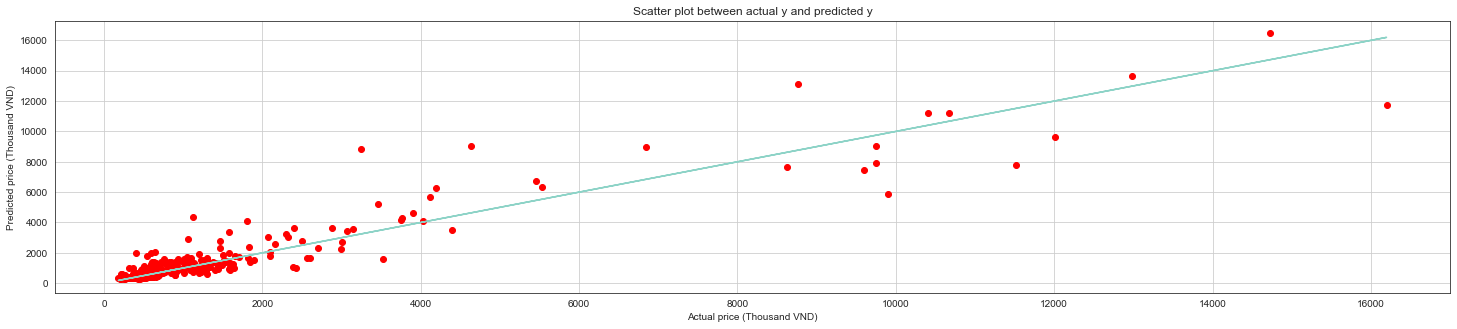

{'n_estimators': [100, 200, 300],
 'max_depth': [10, 20, 30],
 'min_samples_split': [2, 4, 8],
 'min_samples_leaf': [1, 2, 4],
 'max_features': [2, 3, 4],
 'bootstrap': [True, False]}

In [22]:
rdf = ModelRandomForest(model = RandomForestRegressor())
rdf.train(X_train, y_train)
rdf_y_pred = rdf.predict(X_val)
rdf_score_mae, rdf_score_rmse, rdf_score_mape, rdf_r2 = rdf.evaluate(y_val)
rdf.line_graph(25, 5, y_val)
rdf.plot_yy(25, 5, rdf_y_pred, y_val)
rdf.params

In [23]:
print(rdf.model.score(X_train, y_train))
print(rdf.model.score(X_val, y_val))

0.9505570848848237
0.8584620550414496


- Random Forest nhìn chung cho dự đoán tốt hơn

In [24]:
rdf_xg = ModelRandomForest(model = RandomForestRegressor(), search = True)
rdf_xg.train(X_train, y_train)
rdf_xg_y_pred = rdf_xg.predict(X_val)
rdf_score_mae, rdf_score_rmse, rdf_score_mape, rdf_r2 = rdf_xg.evaluate(y_val)
rdf_xg.line_graph(25, 5, y_val)
rdf_xg.plot_yy(25, 5, rdf_xg_y_pred, y_val)
print(rdf_xg.params)

Fitting 6 folds for each of 486 candidates, totalling 2916 fits


KeyboardInterrupt: 

In [ ]:
print(rdf_xg.model.score(X_train, y_train))
print(rdf_xg.model.score(X_val, y_val))

0.84836027653832
0.8432086769680268


- Grid Search nhìn chung có cải thiện hiệu suất mô hình, nhưng không quá đáng kể

### Thử nghiệm sử dụng XGBoost cho bài toán dự đoán

Fitting 6 folds for each of 486 candidates, totalling 2916 fits
make_scorer(r2_score, response_method='predict')
MAE: 472.033007148415
RMSE: 913.1313861939167
MAPE: 0.4198547970470454
R2: 0.841653448240938


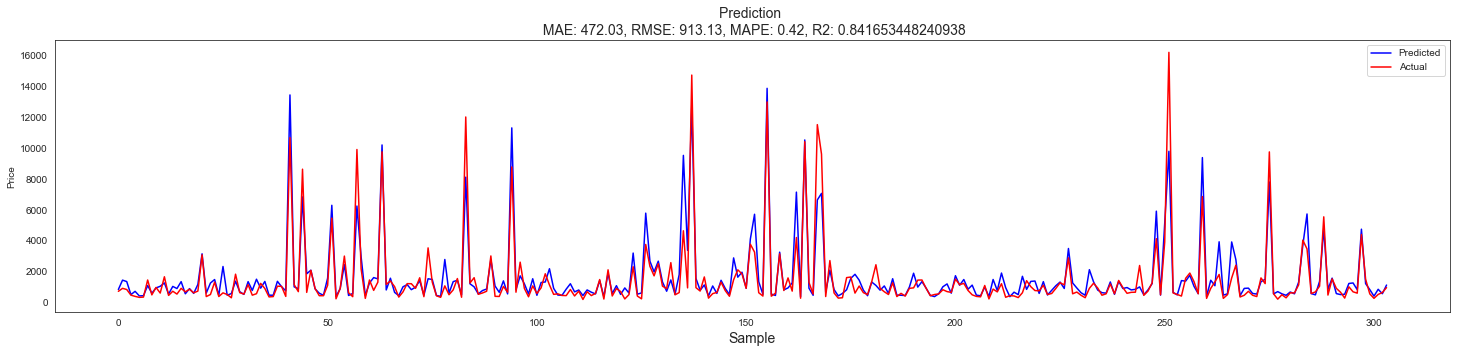

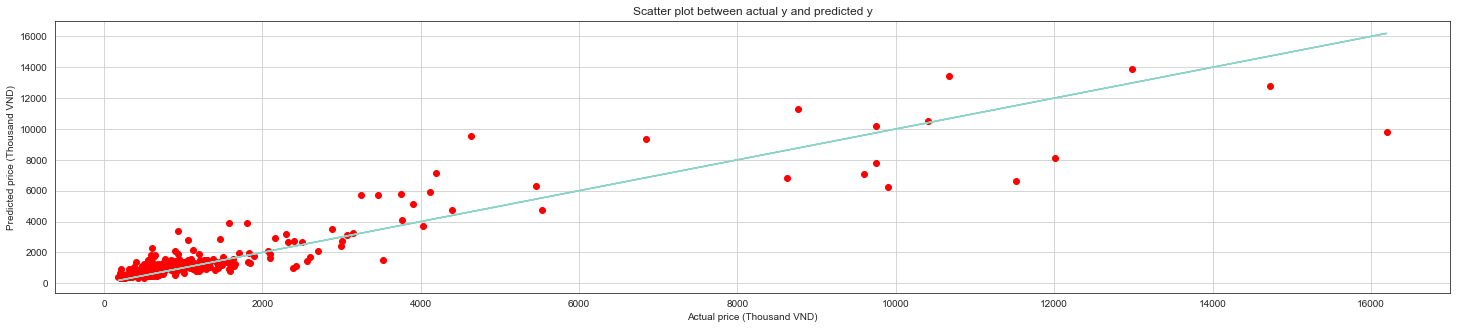

{'bootstrap': True, 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
rdf_xg = ModelRandomForest(model = XGBRegressor(), search=True)
rdf_xg.train(X_train, y_train)
rdf_xg_y_pred = rdf_xg.predict(X_val)
rdf_score_mae, rdf_score_rmse, rdf_score_mape, rdf_r2 = rdf_xg.evaluate(y_val)
rdf_xg.line_graph(25, 5, y_val)
rdf_xg.plot_yy(25, 5, rdf_xg_y_pred, y_val)
print(rdf_xg.params)

In [ ]:
print(rdf_xg.model.score(X_train, y_train))
print(rdf_xg.model.score(X_val, y_val))

0.9568141775909144
0.841653448240938


## KẾT LUẬN
- Vì dữ liệu có nhiều outlier nên trước hết ta áp dụng Robust Scaler để mô hình có thể học tốt hơn.
- Áp dụng PCA không có quá nhiều cải thiện đối với hiệu suất mô hình
- Nhìn chung, Random Forest cho kết quả tốt hơn Linear Regression, đặc biệt là đối với các mức giá cao
- Kết quả dự đoán có thể chấp nhận được, có thể cải thiện hơn bằng nhiều cách như:
    - Thu thập thêm nhiều dữ liệu (đặc biệt là các khách sạn có các mức giá cao, trên 5 triệu đồng)
    - Thu thập và phân tích thêm nhiều đặc trưng
- XGBoost và GridSearch không giúp cải thiện đáng kể mô hình, khả năng cao là vì dữ liệu còn quá ít để mô hình có thể học và khám phá
